In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats
from sklearn import svm

In [2]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased")

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertM

In [3]:
from bert_transformer import BertTransformer

bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [4]:
X_string = 'nlp_3', 'nlp_2', 'nlp_5', 'nlp_4' #tuple
Y_string = 'GDT_score'
DATASET = 'NLP_CLEAN.xlsx'

In [5]:
df = pd.read_excel(io=DATASET)
df = df[df['time'] > 300]
df = df[df['label'] != 1]
# df = df[df['age'] > 30]
# df = df[df['is_male'] == 1]
df = df.reset_index()

for item in [f'nlp_{i}' for i in range(2, 6)]:
    df = df[df[item].apply(lambda x: len(x) > 10)]
    print(len(df))


468
460
449
433


In [6]:
all_x = []

for item in X_string:

    item_processed = bert_transformer.transform(list(df[item]))
    all_x.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

all_x = tuple(all_x)
X = np.hstack(all_x)

y = df[Y_string].values
X.shape

nlp_4 added to list


(433, 3072)

In [7]:
pilot_df = pd.read_excel('NLP_PILOT.XLSX')

for item in [f'nlp_{i}' for i in range(2, 6)]:
    pilot_df = pilot_df[pilot_df[item].apply(lambda x: len(x) > 10)]
    print(len(pilot_df))

95
94
92
91


In [8]:
pilot_X = []

for item in X_string:

    item_processed = bert_transformer.transform(list(pilot_df[item]))
    pilot_X.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

pilot_X = tuple(pilot_X)
pilot_X = np.hstack(pilot_X)

pilot_Y = pilot_df[Y_string].values
pilot_X.shape

nlp_4 added to list


(91, 3072)

In [9]:
SVR_function = svm.SVR(kernel='linear', C=0.019, tol=1e-3)

In [10]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

true_data = []
results = []


for train_index, test_index in kfold.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

   
    vector_regression = SVR_function
    vector_regression.fit(X_train, y_train)
    result = vector_regression.predict(X_test)

    result = [float(item) for item in result]
    results = np.concatenate((results, result))
    true_data = np.concatenate((true_data, y_test))

    print(stats.pearsonr(result, y_test))


PearsonRResult(statistic=0.3780209130477397, pvalue=0.01140706550743288)
PearsonRResult(statistic=0.4379813792228988, pvalue=0.0029450560324088704)
PearsonRResult(statistic=0.5132468490906, pvalue=0.00036701827459743126)
PearsonRResult(statistic=0.47464960025850433, pvalue=0.0013004333916829753)
PearsonRResult(statistic=0.5655014220017267, pvalue=7.766504085694541e-05)
PearsonRResult(statistic=0.5671645555456758, pvalue=7.318328740911821e-05)
PearsonRResult(statistic=0.2816041005593031, pvalue=0.06733869404088083)
PearsonRResult(statistic=0.23251991547253364, pvalue=0.13349619716603478)
PearsonRResult(statistic=0.5904373828544794, pvalue=3.0771737435047455e-05)
PearsonRResult(statistic=0.6114554898434785, pvalue=1.3257799544434448e-05)


In [11]:
#WHOLE DATASET

results = [item if item >= 4 else 4 for item in results]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, true_data))

PearsonRResult(statistic=0.45915490320374247, pvalue=5.752729945375738e-24)


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


mae = mean_absolute_error(true_data, results)
mse = mean_squared_error(true_data, results)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

MAE: 2.46
MSE: 10.77


In [13]:
answers_tuples = [(y, res) for y, res in zip(y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(item) for item in result]

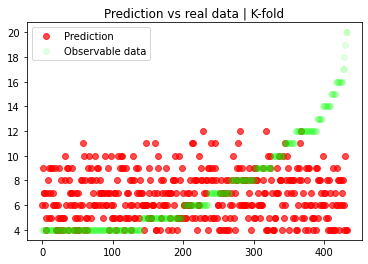

In [14]:
plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.1], label='Observable data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | K-fold')
plt.show()

In [15]:
# Using model to predict pilot data

vector_regression_pilot = SVR_function
vector_regression_pilot.fit(X, y)

SVR(C=0.019, kernel='linear')

In [16]:
prediction = vector_regression_pilot.predict(pilot_X)
prediction = [float(item) for item in prediction]

results = [item if item >= 4 else 4 for item in prediction]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, pilot_Y))

PearsonRResult(statistic=0.2887301914088576, pvalue=0.005509814050128009)


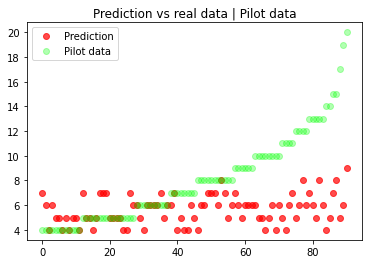

In [17]:
answers_tuples = [(y, res) for y, res in zip(pilot_Y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(int(item)) for item in result]

plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.3], label='Pilot data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | Pilot data')
plt.show()